In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re


In [3]:
data = pd.read_csv(r"/content/amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [4]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
print(f"Feature names: {data.columns.values}")

Feature names: ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [6]:
data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [7]:
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [8]:
data.dropna(inplace = True)

In [9]:
data.shape

(3149, 5)

In [10]:
data['length'] = data['verified_reviews'].apply(len)

In [11]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [12]:
data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
length,int64


Analysing 'rating' column

In [13]:
data['rating'].value_counts()

,count
rating,
5,2286
4,455
1,161
3,152
2,95


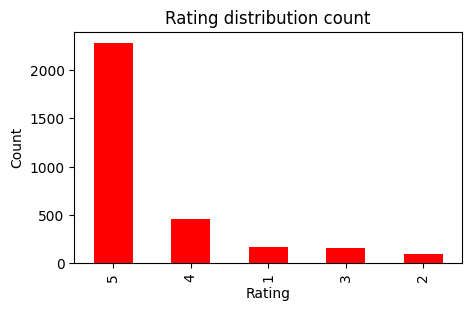

In [14]:
plt.figure(figsize = (5, 3))
data['rating'].value_counts().plot.bar(color = 'red')
plt.title("Rating distribution count")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [15]:
print(f"percentage distribution: \n{data['rating'].value_counts(normalize = True) * 100}")

percentage distribution: 
rating
5    72.594474
4    14.449031
1     5.112734
3     4.826929
2     3.016831
Name: proportion, dtype: float64


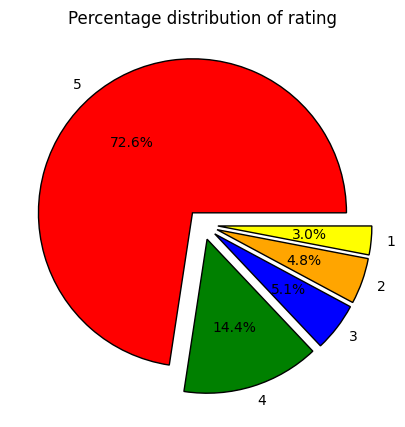

In [16]:
colors = ('red', 'green', 'blue', 'orange', 'yellow')
wp = {'linewidth': 1, 'edgecolor': 'black'}
tags = data['rating'].value_counts()/data.shape[0]
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
plt.figure(figsize = (5, 5))
plt.pie(tags, autopct = '%1.1f%%', explode = explode, labels = ['5', '4', '3', '2', '1'], colors = colors, wedgeprops = wp)
plt.title("Percentage distribution of rating")
plt.show()

Analyzing 'feedback' column

In [17]:
data['feedback'].value_counts()

,count
feedback,
1,2893
0,256


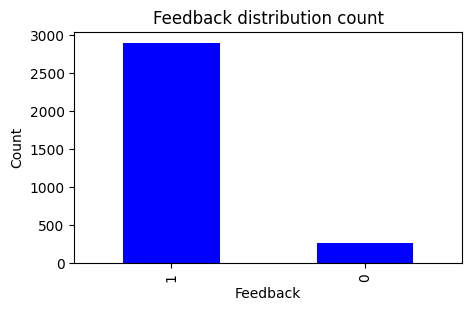

In [18]:
plt.figure(figsize = (5, 3))
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title("Feedback distribution count")
plt.xlabel("Feedback")
plt.ylabel("Count")
plt.show()

In [19]:
data[data['feedback'] == 0]['rating'].value_counts()

,count
rating,
1,161
2,95


In [20]:
data[data['feedback'] == 1]['rating'].value_counts()

,count
rating,
5,2286
4,455
3,152


Analysing 'variation' column

In [21]:
data['variation'].value_counts()

,count
variation,
Black Dot,516
Charcoal Fabric,430
Configuration: Fire TV Stick,350
Black Plus,270
Black Show,265
Black,261
Black Spot,241
White Dot,184
Heather Gray Fabric,157


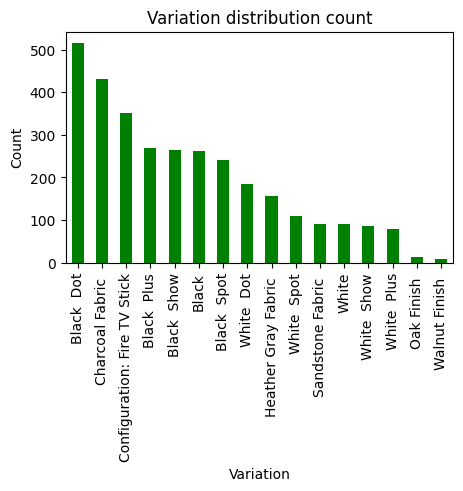

In [22]:
plt.figure(figsize = (5, 3))
data['variation'].value_counts().plot.bar(color = 'green')
plt.title("Variation distribution count")
plt.xlabel("Variation")
plt.ylabel("Count")
plt.show()

In [23]:
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


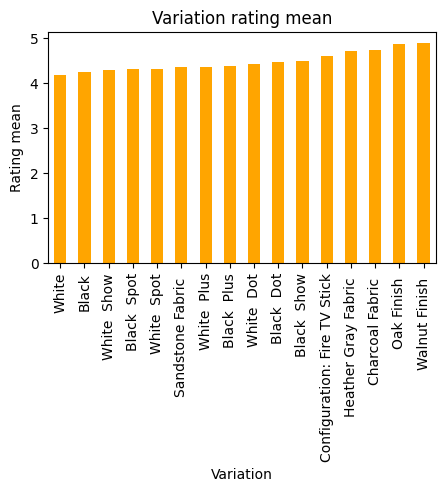

In [25]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'orange', figsize=(5, 3))
plt.title("Variation rating mean")
plt.xlabel("Variation")
plt.ylabel("Rating mean")
plt.show()

Analyzing 'verified_reviews'column

In [26]:
data['length'].describe()

,length
count,3149.000000
mean,132.714513
std,182.541531
min,1.000000
25%,30.000000
50%,74.000000
75%,166.000000
max,2853.000000


In [28]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(data['verified_reviews'])

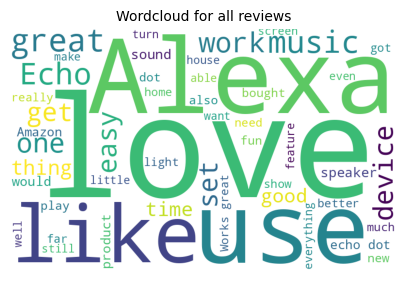

In [30]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

# Initialize wordcloud object
wc = WordCloud(width = 800, height = 500, background_color = 'white', max_words=50, stopwords = STOPWORDS)

# Generate wordcloud
plt.figure(figsize=(5,5))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following

1. Replace any non alphabet characters with a space
2. Convert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [31]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [32]:
cv = CountVectorizer(max_features = 2500)
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [33]:
# Saving the Count Vectorizer
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

In [35]:
print(X.shape)
y.shape

(3149, 2500)


(3149,)

Splitting into training and test data

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)

In [37]:
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [38]:
# Saving the scaler model
pickle.dump(scaler, open('scaler.pkl', 'wb'))

**Random Forest**

In [39]:
# Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [40]:
# Accuracy on training and test data

print(f"Accuracy on training data: {model_rf.score(X_train_scl, y_train)}")
print(f"Accuracy on test data: {model_rf.score(X_test_scl, y_test)}")

Accuracy on training data: 0.9948392219134577
Accuracy on test data: 0.9412698412698413


In [42]:
# Predicting on the test set
y_pred = model_rf.predict(X_test_scl)

In [43]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 18  35]
 [  2 575]]


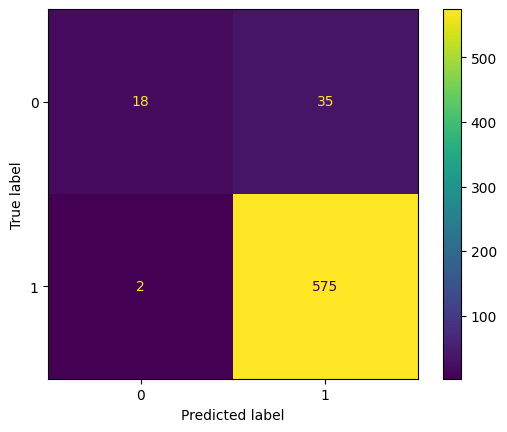

In [46]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_).plot()
plt.show()

K fold cross-validation

In [47]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)
print(f"Accuracy: {accuracies.mean()*100} %")
print(f"Standard Deviation: {accuracies.std()*100} %")

Accuracy: 93.88699171567698 %
Standard Deviation: 1.004501062494372 %


Applying grid search to get the optimal parameters on random forest"

In [51]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [52]:
cv_object = StratifiedKFold(n_splits=2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score= True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [53]:
# Getting the best parameter from the grid search

print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 100}


In [54]:
print("Cross validation mean accuracy on train set: {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set: {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set:", accuracy_score(y_test, y_pred))

Cross validation mean accuracy on train set: 97.00283750646142
Cross validation mean accuracy on test set: 92.25390285184764
Accuracy score for test set: 0.9412698412698413


**XGBoost**

In [55]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [56]:
# Accuracy of model on training and test data

print(f"Accuracy on training data: {model_xgb.score(X_train_scl, y_train)}")
print(f"Accuracy on test data: {model_xgb.score(X_test_scl, y_test)}")

Accuracy on training data: 0.9730051607780865
Accuracy on test data: 0.9428571428571428


In [57]:
y_preds = model_xgb.predict(X_test_scl)

In [58]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 21  32]
 [  4 573]]


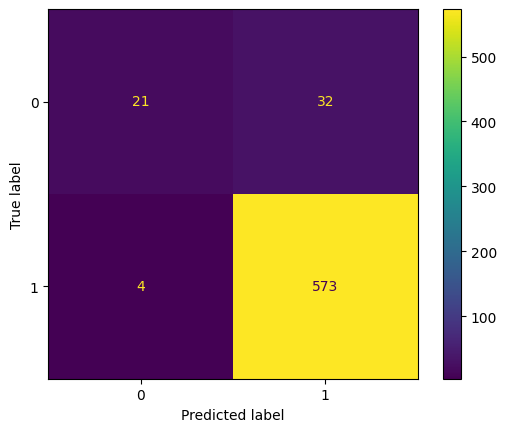

In [60]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_).plot()
plt.show()

In [61]:
# Saving the XGBoost classifier
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

**Decision Tree Classifier**

In [62]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [63]:
# Accuracy on traing and test

print(f"Accuracy on training data: {model_dt.score(X_train_scl, y_train)}")
print(f"Accuracy on test data: {model_dt.score(X_test_scl, y_test)}")

Accuracy on training data: 0.9948392219134577
Accuracy on test data: 0.9333333333333333


In [64]:
y_preds = model_dt.predict(X_test)

In [65]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 31  22]
 [ 20 557]]


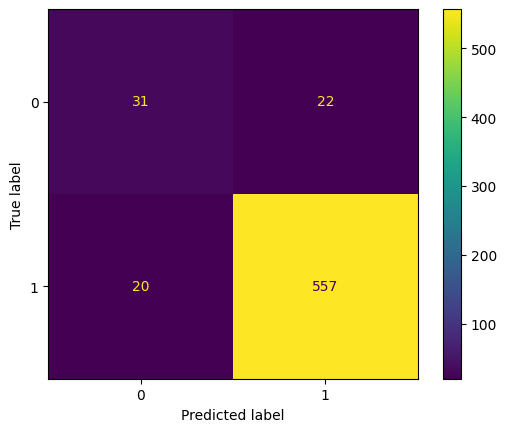

In [66]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_).plot()
plt.show()

In [67]:
pickle.dump(model_rf, open('model_rf.pkl', 'wb'))